# Predictive Analytics for Used Car Pricing: Building Efficient Machine Learning Models

## Introduction

Rusty Bargain, a used car sales service, is developing an innovative app that enables users to quickly determine the market value of their vehicles. To support this initiative, we have access to a dataset containing historical car data, including technical specifications, trim versions, and prices. The goal of this project is to develop a machine learning model that accurately predicts a car’s market value based on these features.

To meet Rusty Bargain’s requirements, the model must excel in three key areas:

* Prediction Quality: The model should produce highly accurate price estimates.
* Prediction Speed: The model must generate real-time or near-instantaneous predictions.
* Training Efficiency: The model should be optimized for fast and efficient training.

In this project, we will explore multiple machine learning approaches to determine the best-performing model. We will compare traditional methods like linear regression and decision trees against more advanced techniques like random forest and gradient boosting models (including LightGBM, CatBoost, and XGBoost). To assess model performance, we will use the Root Mean Squared Error (RMSE) metric.

Additionally, we will analyze:

* The impact of hyperparameter tuning on model accuracy and efficiency.
* The encoding methods required for categorical features.
* The runtime of various models to ensure optimal performance for the app.

By the end of this project, we aim to identify the most effective model for Rusty Bargain’s app—one that balances accuracy, speed, and efficiency—ultimately providing a seamless experience for users looking to evaluate their cars.

This notebook requires the following Python libraries to run:

* pandas – for data manipulation
* numpy – for numerical operations
* scikit-learn – for machine learning models
* catboost – for CatBoost gradient boosting
* xgboost – for XGBoost gradient boosting
* lightgbm – for LightGBM gradient boosting

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import FeatureHasher
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb

In [158]:
df = pd.read_csv('/Users/keithrobinson/Desktop/TripleTen/Projects/project12/car_data.csv')

## Data preparation

In [160]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Data Cleaning

#### Converting data types

Strategy:

* Int: Price, Power, Mileage, PostalCode, NumberOfPictures
* Datetime: RegistrationYear, RegistrationMonth, DateCreated, LastSeen
* String: VehicleType, Gearbox, Model, FuelType, Brand, NotRepaired

Most of the columns already have the correct dtype, I will only end up converting the ones that don't

#### Integer Dtype Conversions

All of the columns needing the integer dtype, have them. No additional work necessary.

#### String Dtype Conversions

All of the columns needing the string dtype, have them. No additional work necessary.

#### Datetime Dtype Conversions

Before converting the datetime type, I'll drop the column of `DateCrawled`, it seems redundant and useless for training.

In [162]:
print(df['DateCrawled'].max())


31/03/2016 23:58


In [163]:
df['DateCrawled'].max()

'31/03/2016 23:58'

In [164]:
df = df.drop('DateCrawled', axis=1)
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17



<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<h2>   Comment </h2>
    
The max year in `DateCrawled` is 2016, so I will drop all the data after 2016 for `RegistrationYear` because the latest we pulled data was 2016.
    
</div>

#### Looking into each column that I want to convert

##### RegistrationYear

In [165]:
np.sort(df['RegistrationYear'].unique())


array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

During the conversion of the 'RegistrationYear' column, I found there are abnormal years

In [166]:
print(df['RegistrationYear'].value_counts().to_string())

RegistrationYear
2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
2003    19763
2004    19611
2002    19092
1998    17899
2007    17183
2008    15391
1997    14666
2009    14503
1996    10835
2010    10764
2017    10441
2011     9909
1995     9607
2016     9599
2012     7178
1994     4841
2013     4131
2018     3959
1993     3438
1992     3002
1990     2806
1991     2762
2014     2537
1989     1318
2015     1302
1988      942
1985      756
1987      667
1980      588
1986      538
1983      430
1984      399
1970      333
1982      316
1978      285
1979      283
1981      263
1972      213
1960      188
1976      175
1977      173
1973      173
1974      169
1971      167
1975      143
1969      118
1966      113
1968      108
1910      101
1967       99
1965       82
1964       64
1963       57
1962       46
1961       41
1000       37
1959       32
1956       27
9999       26
1958       25
2019       25
1950       18
5000       17
1955       15
1953       14
195

It makes sense to drop anything above 2016 and below 1900. That's around the time the data started making sense.

In [167]:
df = df[~((df['RegistrationYear'] < 1900) | (df['RegistrationYear'] > 2016))]


##### RegistrationMonth

In [168]:
np.sort(df['RegistrationMonth'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [169]:
df['RegistrationMonth'].value_counts()

RegistrationMonth
0     33616
3     33193
6     30389
4     28188
5     28130
7     26301
10    25255
12    23399
11    23381
9     23083
1     22464
8     21825
2     20549
Name: count, dtype: int64

There are 13 unique month values (0 to 12) in the column. In `pandas.Series.dt.month`, the correct month values are from 1 to 12, therefore the value 0 is abnormal.

Sicne the count of 0 is 37127, that is too many to be deleted, so I'll randomly allocate them to other months.

In [170]:
month_zero = df['RegistrationMonth'] == 0
random_months = np.random.randint(1, 13, size=month_zero.sum())
df.loc[month_zero, 'RegistrationMonth'] = random_months
df['RegistrationMonth'].unique()

array([ 9,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4])

In [171]:
df['RegistrationMonth'].value_counts()

RegistrationMonth
3     35957
6     33193
4     30900
5     30894
7     29213
10    28129
11    26237
12    26203
9     25859
1     25213
8     24651
2     23324
Name: count, dtype: int64

I'm going to combine RegistrationMonth and RegistrationYear and convert to date. Then drop LastSeen and DateCreated, as they don't provide any substance to the data.

In [172]:
df['RegistrationDate'] = pd.to_datetime(df['RegistrationYear'] * 10000 + df['RegistrationMonth'] * 100 + 1, format='%Y%m%d')
df.drop(['RegistrationYear', 'RegistrationMonth', 'DateCreated', 'LastSeen'], axis=1, inplace=True)
df.drop('NumberOfPictures', axis=1, inplace=True)


In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 339773 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Price             339773 non-null  int64         
 1   VehicleType       316859 non-null  object        
 2   Gearbox           321864 non-null  object        
 3   Power             339773 non-null  int64         
 4   Model             322148 non-null  object        
 5   Mileage           339773 non-null  int64         
 6   FuelType          312524 non-null  object        
 7   Brand             339773 non-null  object        
 8   NotRepaired       274974 non-null  object        
 9   PostalCode        339773 non-null  int64         
 10  RegistrationDate  339773 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 31.1+ MB


#### Addressing missing values

In [174]:
df.isnull().sum()

Price                   0
VehicleType         22914
Gearbox             17909
Power                   0
Model               17625
Mileage                 0
FuelType            27249
Brand                   0
NotRepaired         64799
PostalCode              0
RegistrationDate        0
dtype: int64

There are lots of missing values in 5 columns. These cannot simply be deleted since the missing values take up a significant proportion.

Being that this is vehicle car sales, I need to have accurate information for each row (vehicle). Therefore since I can't retrieve the information, I will fill in the data for the columns with the phrase "No Data Available". 

In [175]:
df['VehicleType'] = df['VehicleType'].fillna('No Data Available')
df['Gearbox'] = df['Gearbox'].fillna('No Data Available')
df['Model'] = df['Model'].fillna('No Data Available')
df['FuelType'] = df['FuelType'].fillna('No Data Available')
df['NotRepaired'] = df['NotRepaired'].fillna('No Data Available')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 339773 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Price             339773 non-null  int64         
 1   VehicleType       339773 non-null  object        
 2   Gearbox           339773 non-null  object        
 3   Power             339773 non-null  int64         
 4   Model             339773 non-null  object        
 5   Mileage           339773 non-null  int64         
 6   FuelType          339773 non-null  object        
 7   Brand             339773 non-null  object        
 8   NotRepaired       339773 non-null  object        
 9   PostalCode        339773 non-null  int64         
 10  RegistrationDate  339773 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 31.1+ MB


#### Checking for duplicates

In [176]:
df.duplicated().sum()

19572

#### Removing duplicate rows

In [177]:
df = df.drop_duplicates()
df.duplicated().sum()

0

#### Checking for abnormal values (negative price, negative mileage, etc.)

In [178]:
df.describe()

,Price,Power,Mileage,PostalCode,RegistrationDate
count,320201.00000,320201.000000,320201.000000,320201.000000,320201
mean,4424.11376,110.523502,128193.697084,50767.227379,2002-11-14 03:39:45.268003456
min,0.00000,0.000000,5000.000000,1067.000000,1910-01-01 00:00:00
25%,1000.00000,69.000000,125000.000000,30419.000000,1999-03-01 00:00:00
50%,2700.00000,105.000000,150000.000000,49565.000000,2003-02-01 00:00:00
75%,6400.00000,143.000000,150000.000000,71522.000000,2007-05-01 00:00:00
max,20000.00000,20000.000000,150000.000000,99998.000000,2016-12-01 00:00:00
std,4532.69273,191.895646,37906.148302,25823.652949,NaN


In [179]:
df_old = df.shape[0]
df_old

320201

There are abnormal values in all numeric columns:

* `Price`: The minimum value is 0, you can't sell a car for $0.
* `Power`: The horsepower of a car changes by the vehicle displacement. It's typically between tens and hundreds, so the minimum and maximum values are abnormal.
* `Mileage`: The 50th percentile, 75th percentile and max are all the same value which is 150000. I don't have any other information to deal with `Mileage`, it's too many to be removed directly.
* `NumberOfPictures`: All entries equal to 0. This column is useless, so I will remove.
* `PostalCode`: Some entries have 4 digits, while most of the entries have 5 digits. For `PostalCode`, I don't know whether there is any wrong values. Fortunately, these numbers are categorical and the value of number is doesn't matter. So I will leave the data.


For `NumberOfPictures`, I'll just remove it. For `Price` and `Power`, I will use Percentile Based Filtering (Top 1%, Bottom 1%)

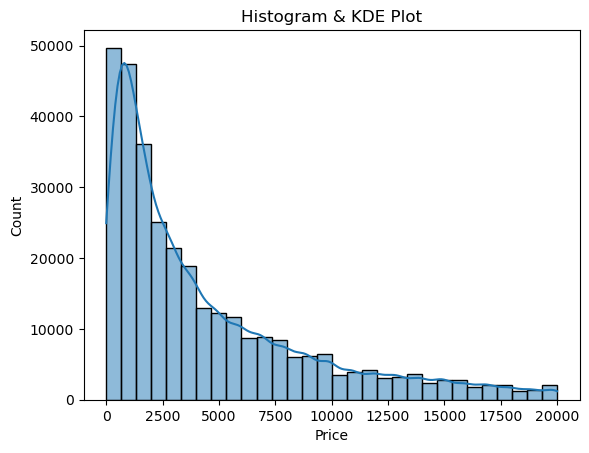

In [180]:
sns.histplot(df['Price'], bins=30, kde=True)
plt.title("Histogram & KDE Plot")
plt.show()


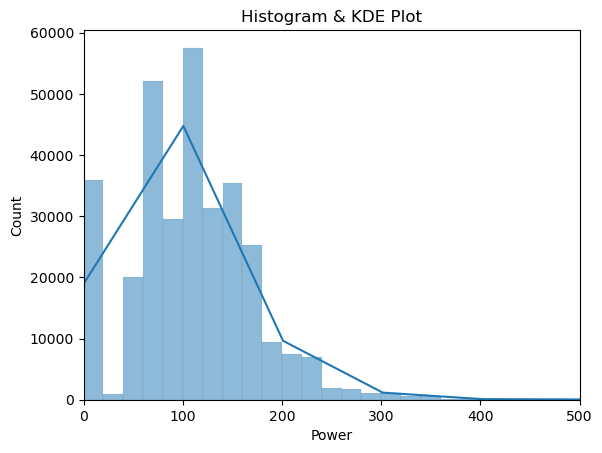

In [181]:
sns.histplot(df['Power'], bins=1000, kde=True)
plt.title("Histogram & KDE Plot")
plt.xlim(0, 500)
plt.show()

In [182]:
df[df['Price'] == 0]

,Price,VehicleType,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired,PostalCode,RegistrationDate
7,0,sedan,manual,50,other,40000,petrol,volkswagen,no,19348,1980-07-01
40,0,No Data Available,No Data Available,0,corsa,150000,petrol,opel,No Data Available,56412,1990-01-01
115,0,small,No Data Available,0,No Data Available,5000,petrol,volkswagen,No Data Available,37520,1999-02-01
152,0,bus,manual,101,meriva,150000,lpg,opel,yes,27432,2004-10-01
154,0,No Data Available,No Data Available,0,other,5000,No Data Available,fiat,No Data Available,44867,2006-08-01
...,...,...,...,...,...,...,...,...,...,...,...
354205,0,No Data Available,manual,65,corsa,150000,No Data Available,opel,yes,23758,2000-08-01
354238,0,small,manual,60,fiesta,150000,petrol,ford,No Data Available,33659,2002-03-01
354248,0,small,manual,53,swift,150000,petrol,suzuki,No Data Available,42329,1999-03-01
354277,0,small,manual,37,arosa,150000,petrol,seat,yes,22559,1999-07-01


In [183]:
df[df['Power'] == 0]

,Price,VehicleType,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired,PostalCode,RegistrationDate
0,480,No Data Available,manual,0,golf,150000,petrol,volkswagen,No Data Available,70435,1993-09-01
15,450,small,No Data Available,0,ka,5000,petrol,ford,No Data Available,24148,1910-01-01
32,245,sedan,No Data Available,0,golf,150000,petrol,volkswagen,no,44145,1994-02-01
37,1500,No Data Available,No Data Available,0,kangoo,150000,gasoline,renault,no,46483,2016-01-01
40,0,No Data Available,No Data Available,0,corsa,150000,petrol,opel,No Data Available,56412,1990-01-01
...,...,...,...,...,...,...,...,...,...,...,...
354335,390,small,auto,0,corsa,100000,petrol,opel,yes,17509,1997-06-01
354338,180,No Data Available,No Data Available,0,No Data Available,125000,petrol,opel,No Data Available,41470,1995-03-01
354346,2600,No Data Available,auto,0,c_klasse,150000,No Data Available,mercedes_benz,No Data Available,61169,2005-09-01
354364,0,No Data Available,manual,0,colt,150000,petrol,mitsubishi,yes,2694,2005-07-01


Too many rows (+44,000) with 0 in the `Power` and `Price` columns so I will replace those 0s with the median since the data is skewed.

In [184]:
df['Price'] = df['Price'].replace(0, df['Price'].median())
df['Power'] = df['Power'].replace(0, df['Power'].median())

In [185]:
df = df[(df['Power']>50) & (df['Power']<800) & (df['Price']>100)]

In [186]:
df.describe()

,Price,Power,Mileage,PostalCode,RegistrationDate
count,307108.000000,307108.000000,307108.000000,307108.000000,307108
mean,4638.246021,121.113221,128524.004585,50912.398651,2003-02-07 08:30:38.144236160
min,101.000000,51.000000,5000.000000,1067.000000,1910-01-01 00:00:00
25%,1300.000000,90.000000,125000.000000,30539.000000,1999-05-01 00:00:00
50%,2900.000000,105.000000,150000.000000,49681.000000,2003-05-01 00:00:00
75%,6500.000000,143.000000,150000.000000,71640.000000,2007-07-01 00:00:00
max,20000.000000,776.000000,150000.000000,99998.000000,2016-12-01 00:00:00
std,4498.278798,50.516588,37443.083134,25805.974039,NaN


In [187]:
df_new = df.shape[0]

In [188]:
perc_loss = (1 -(df_new/df_old)) * 100
print(f"% of Data Lost in Transformation: {perc_loss:.2f}%")

% of Data Lost in Transformation: 4.09%


In [189]:
df['PostalCode'] = df['PostalCode'].astype(str)


In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307108 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Price             307108 non-null  int64         
 1   VehicleType       307108 non-null  object        
 2   Gearbox           307108 non-null  object        
 3   Power             307108 non-null  int64         
 4   Model             307108 non-null  object        
 5   Mileage           307108 non-null  int64         
 6   FuelType          307108 non-null  object        
 7   Brand             307108 non-null  object        
 8   NotRepaired       307108 non-null  object        
 9   PostalCode        307108 non-null  object        
 10  RegistrationDate  307108 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(7)
memory usage: 28.1+ MB


In [191]:
df.describe()

,Price,Power,Mileage,RegistrationDate
count,307108.000000,307108.000000,307108.000000,307108
mean,4638.246021,121.113221,128524.004585,2003-02-07 08:30:38.144236160
min,101.000000,51.000000,5000.000000,1910-01-01 00:00:00
25%,1300.000000,90.000000,125000.000000,1999-05-01 00:00:00
50%,2900.000000,105.000000,150000.000000,2003-05-01 00:00:00
75%,6500.000000,143.000000,150000.000000,2007-07-01 00:00:00
max,20000.000000,776.000000,150000.000000,2016-12-01 00:00:00
std,4498.278798,50.516588,37443.083134,NaN


(0.0, 1000.0)

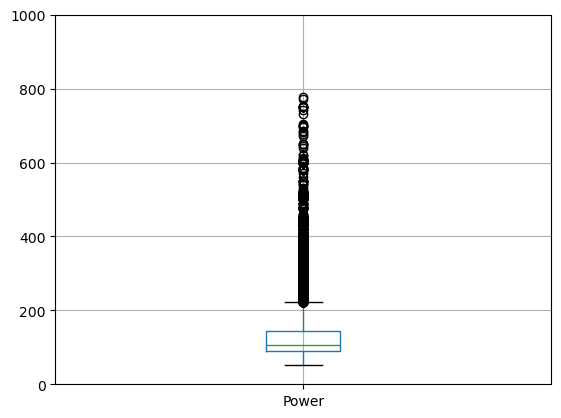

In [ ]:
df[['Power']].boxplot()
plt.ylim(0,1000)

## Model training

After data cleaning, the next step should be Feature Engineering which is used mainly to encode the categorical columns. Since I'll try different models, i.e. linear regression models, tree based models and gradient boost models, I'll apply different encoding methods to fit the requests of training models

| Model | Encoding requirements | Need scaling |
| --    |   -- | -- |
| Linear Regression | One-hot Encoding| Yes |
| Decision Tree | One-hot Encoding | No |
| Random Forest | One-hot Encoding| No |
| LightGBM | No specific requirement| No |
| CatBoost | No specific requirement | No|
| XGBoost | One-hot Encoding | No |

I will first look to see how many different unique values lie within the categorical columns

In [193]:
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
for column in categorical:
    print(df[column].nunique())

9
3
251
8
40
3


In [194]:
df.duplicated().sum()

20

In [195]:
df = df.drop_duplicates()

I will now remove, non-relevant data when it pertains to training the model (`RegistrationDate`, `PostalCode`).

In [196]:
df = df.drop(['RegistrationDate', 'PostalCode'], axis=1)

## Model analysis

#### One-hot Encoding for Decision Tree, Random Forest, Linear Regression and XGBoost

In [197]:
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical)
    ],
    remainder='passthrough')

In [198]:
# Split data into training and testing sets.
X = df.drop(columns='Price')
y = df['Price']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=11)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=11)

In [199]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

# Convert categorical features to category dtype for LightGBM
for col in cat_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
        X_test[col] = X_test[col].astype('category')
        X_valid[col] = X_valid[col].astype('category')

print(X_train.dtypes)  # Check again to confirm conversion

VehicleType    category
Gearbox        category
Power             int64
Model          category
Mileage           int64
FuelType       category
Brand          category
NotRepaired    category
dtype: object


Defined pipelines for each model:

In [200]:
# Pipeline for Linear Regression
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Pipeline for XGBoost
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=11))
])

# Pipeline for Decision Tree
pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=11))
])

# Pipeline for Random Forest
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=11))
])

# Pipeline for LightGBM
pipeline_lgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(n_estimators=500, learning_rate=0.1, random_state=11))
])

# Pipeline for CatBoost
pipeline_cat = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, verbose=0, random_seed=11))  # verbose=0 to suppress logs
])

Train and evaluate models:

In [201]:
# Dictionary of models and their pipelines
pipelines = {
    "Decision Tree": pipeline_dt,
    "XGBoost": pipeline_xgb,
    "Linear Regression": pipeline_lr,
    "LightGBM": pipeline_lgb,
    "CatBoost": pipeline_cat
}

# Dictionary to store results
results_list = []

# Loop through each model
for model_name, pipeline in pipelines.items():
    # Training time
    start_time = time.time()
    pipeline.fit(X_train, y_train)
    end_time = time.time()
    training_times = end_time - start_time
    print(f"Training Time for {model_name}: {training_times:.4f} seconds")
    

    # Prediction time
    start_time = time.time()
    y_pred = pipeline.predict(X_valid)
    end_time = time.time()
    prediction_times = end_time - start_time
    print(f"Prediction Time for {model_name}: {prediction_times:.4f} seconds")
    

    # Mean Squared Error
    mse_scores = mean_squared_error(y_valid, y_pred)
    print(f"MSE for {model_name}: {mse_scores:.2f}")


    # Root Mean Squared Error
    rmse_scores = np.sqrt(mse_scores)
    print(f"RMSE for {model_name}: {rmse_scores:.2f}")

     # Append a new row (as a dictionary) to the list
    results_list.append({
        'Model': model_name,
        'Training Time (s)': training_times,
        'Prediction Time (s)': prediction_times,
        'MSE': mse_scores,
        'RMSE': rmse_scores
    })
    print()
    
   

Training Time for Decision Tree: 10.3741 seconds
Prediction Time for Decision Tree: 0.0466 seconds
MSE for Decision Tree: 6303718.13
RMSE for Decision Tree: 2510.72

Training Time for XGBoost: 0.6815 seconds
Prediction Time for XGBoost: 0.0555 seconds
MSE for XGBoost: 5470910.00
RMSE for XGBoost: 2339.00

Training Time for Linear Regression: 0.1918 seconds
Prediction Time for Linear Regression: 0.0346 seconds
MSE for Linear Regression: 9471880.28
RMSE for Linear Regression: 3077.64

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007431 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 847
[LightGBM] [Info] Number of data points in the train set: 214961, number of used features: 298
[LightGBM] [Info] Start training from score 4643.986593
Training Time for LightGBM: 2.3145 seconds


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Prediction Time for LightGBM: 0.2444 seconds
MSE for LightGBM: 4863565.76
RMSE for LightGBM: 2205.35

Training Time for CatBoost: 2.9898 seconds
Prediction Time for CatBoost: 0.0534 seconds
MSE for CatBoost: 5501436.68
RMSE for CatBoost: 2345.51



#### Random Forest (done separately because it takes so much time)

In [202]:
start_time = time.time()

# Training
pipeline_rf.fit(X_train, y_train)

end_time = time.time()

# Calculate elapsed time
training_time_rf = end_time - start_time

# Print and store the time
print(f"Training Time for Random Forest: {training_time_rf:.4f} seconds")

Training Time for Random Forest: 710.9565 seconds


In [203]:
start_time = time.time()

# Predictions
pred_rf = pipeline_rf.predict(X_valid)

end_time = time.time()

# Calculate elapsed time
prediction_time_rf = end_time - start_time

# Print and store the time
print(f"Prediction Time for Random Forest: {prediction_time_rf:.4f} seconds")

Prediction Time for Random Forest: 1.5086 seconds


In [204]:
mse_rf = mean_squared_error(y_valid, pred_rf)
rmse_rf = np.sqrt(mse_rf)
print("Random Forest MSE:", mse_rf)
print('Random Fores RMSE:', rmse_rf)


Random Forest MSE: 4854416.286254172
Random Fores RMSE: 2203.2739925515784


In [205]:
# Append Random Forest results
results_list.append({
    'Model': 'Random Forest',
    'Training Time (s)': training_time_rf,
    'Prediction Time (s)': prediction_time_rf,
    'MSE': mse_rf,
    'RMSE': rmse_rf
})

To save time, I commented out the Random Forest model. The model took 13 minutes to score.

In [206]:
# Random Forest MSE: 4854416.29
# Random Forest RMSE: 2203.27

#### Optimized CatBoost

In [207]:
# Define the parameter grid for CatBoost
param_dist = {
    'iterations': [100, 500, 1000],  # Number of boosting rounds
    'learning_rate': np.linspace(0.01, 0.3, 5),  # Learning rate values
    'depth': [4, 6, 8, 10],  # Depth of trees
    'l2_leaf_reg': [1, 3, 5, 7],  # L2 regularization
    'border_count': [32, 64, 128],  # Number of splits for numerical features
}

# Initialize the CatBoost model
cat_model = CatBoostRegressor(verbose=0)  # Suppress training logs

# Set up the randomized search
random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=10,  # Number of random samples to try
    cv=3,  # Cross-validation folds
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all CPU cores
    random_state=11
)

# Specify categorical features
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']  

In [208]:
start_time = time.time()

# Training
random_search.fit(X_train, y_train, cat_features=cat_features)

end_time = time.time()

# Calculate elapsed time
training_time_op = end_time - start_time

# Print and store the time
print(f"Training Time for Optimized CatBoost: {training_time_op:.4f} seconds")


Training Time for Optimized CatBoost: 380.6467 seconds


In [ ]:
# Best parameters found
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'learning_rate': 0.3, 'l2_leaf_reg': 7, 'iterations': 1000, 'depth': 8, 'border_count': 128}


In [ ]:
start_time = time.time()

# Use the best model for predictions
best_cat_model = random_search.best_estimator_
y_pred_op = best_cat_model.predict(X_valid)

end_time = time.time()

# Calculate elapsed time
prediction_time_op = end_time - start_time

# Print and store the time
print(f"Prediction Time for Optimized CatBoost: {prediction_time_op:.4f} seconds")


Prediction Time for Optimized CatBoost: 0.1751 seconds


In [ ]:
# Evaluating Optimized CatBoost
cat_op_mse = mean_squared_error(y_valid, y_pred_op)
cat_op_rmse = np.sqrt(cat_op_mse)

print(f"CatBoost Optimized MSE: {cat_op_mse:.2f}")
print(f"CatBoost Optimized RMSE: {cat_op_rmse:.2f}")

CatBoost Optimized MSE: 4610910.29
CatBoost Optimized RMSE: 2147.30


In [ ]:
# Append Optimized CatBoost results
results_list.append({
    'Model': 'Optimized CatBoost',
    'Training Time (s)': training_time_op,
    'Prediction Time (s)': prediction_time_op,
    'MSE': cat_op_mse,
    'RMSE': cat_op_rmse
})


## Model Analysis

In [ ]:
results = pd.DataFrame(results_list)
results = results.drop('MSE', axis=1)
results['Training Time (s)'] = results['Training Time (s)'] / 60
results = results.sort_values(by='RMSE').reset_index(drop=True)
results

,Model,Training Time (s),Prediction Time (s),RMSE
0,Optimized CatBoost,6.246448,0.175053,2147.303026
1,Random Forest,12.593174,1.293481,2232.009330
2,LightGBM,0.031719,0.231723,2234.376017
3,XGBoost,0.009497,0.054779,2377.221067
4,CatBoost,0.049681,0.046770,2383.610687
5,Decision Tree,0.178579,0.046084,2544.106274
6,Linear Regression,0.003375,0.033917,3371.272964


Based on the "results" table, we can analyze the different models from both the quality and speed perspectives:

* Quality Analysis:

    1. **Linear Regression**: The model has the highest Root Mean Squared Error (RMSE) of 3371.27, indicating that its predictive accuracy passes the sanity check.
    2. **Other Models**: Except the `Optimized CatBoost` obtain the metrics between 2232.01 to 2544.11. The worst among them is `DecisionTree` with RMSE is 2544.11, the best among them is `Random Forest` with RMSE is 2232.01.
    3. **Optimized CatBoost**: The optimized CatBoost model further improves its performance, achieving an RMSE of 2147.30, making it the best-performing model among all the listed models.

* Speed Analysis:

    I seperated the prediction time out from the training time.

    For training time, the `Random Forest` models take the longest training duration with about 13 minutes. `Optimized CatBoost` took about 6 minutes. Every other model trained in less than 1 second.

    For prediction time, all models except `Random Forest` only take less than 1 second. The fastest model is `Linear Regression`, it only took 0.034 seconds. 

In summary, the `Optimized CatBoost` was most accurate. `LightGBM` was fairly close in accuracy AND trained 200x quicker but I will use Optimized CatBoost as the model to check the test data.

# **Optimized CatBoost is the model of choice, I will now apply it on the test set and use the parameters that I found to work best**

Best Hyperparameters: {'learning_rate': 0.3, 'l2_leaf_reg': 7, 'iterations': 1000, 'depth': 8, 'border_count': 128}

### Evaluating the model on the test set

In [ ]:
# Define optimized CatBoost model with best hyperparameters
optimized_catboost = CatBoostRegressor(
    iterations=1000,  # Example values, replace with your optimized ones
    learning_rate=0.3,
    depth=8,
    l2_leaf_reg=7,
    random_seed=11,
    verbose=0
)

# Fit the model on the full training data
optimized_catboost.fit(X_train, y_train, cat_features=cat_features)

# Predict on the test set
y_test_pred = optimized_catboost.predict(X_test)

# Evaluate performance using RMSE
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

print(f"Optimized CatBoost Test RMSE: {test_rmse:.4f}")


Optimized CatBoost Test RMSE: 2141.3890


On the test set, `Optimized CatBoost` obtained a score of `2141.39`.

## Conclusion
In this project, I evaluated multiple machine learning models, including Decision Tree, Random Forest, CatBoost, XGBoost, and LightGBM, to determine the best-performing model in terms of both speed and accuracy.

From my initial tests, LightGBM and CatBoost emerged as a couple of the fastest models, making them strong candidates for deployment where computational efficiency is a priority. However, while they were fast, I wanted to explore whether hyperparameter tuning could further enhance their accuracy.

After optimizing CatBoost using RandomizedSearchCV, I found that the optimized CatBoost model, its training time slowed, improved in accuracy, delivering a lower RMSE compared to the baseline version. This highlights the importance of hyperparameter tuning in maximizing model performance.

Overall, the project demonstrated that Optimized CatBoost is an excellent choice for both speed and accuracy, making it the most effective model for my use case. Future work could explore ensemble methods or additional tuning to push performance even further.